# Obligatorio - Taller Agentes Inteligentes 2025

En este trabajo obligatorio aplicaremos los conceptos vistos en el curso para diseñar, implementar y evaluar agentes capaces de aprender a jugar al clásico **Breakout** de Atari, utilizando el entorno provisto por Farama Gymnasium ([https://ale.farama.org/environments/breakout/](https://ale.farama.org/environments/breakout/)). 

<p align="center">
  <img src="https://media.tenor.com/oMxHgRrISJsAAAAM/atari-deep-learning.gif" alt="Atari Deep Learning"/>
</p>


El ejercicio se enmarca en un contexto de aprendizaje práctico, donde trabajaremos con las interfaces estándar de Gymnasium para:

1. **Profundizar en algoritmos de valor**: implementaremos y compararemos dos variantes de Q-Learning basadas en redes neuronales profundas:
   * **Deep Q Learning (DQN)**
   * **Double Deep Q Learning (DDQN)**
2. **Evaluar rendimiento y estabilidad**: registraremos las recompensas obtenidas durante el entrenamiento de cada agente y analizaremos su comportamiento mediante gráficas comparativas.
3. **Demostrar resultados de forma visual**: capturaremos vídeos que muestren a cada agente “resolviendo” el entorno, entendido como la habilidad de romper al menos cinco bloques en una partida.

Debido a las limitaciones de tiempo y cómputo propias de un entorno de curso, no se espera entrenar modelos durante más de diez horas por agente. Por ello, será fundamental:

* Integrar puntos de **checkpoint** para guardar periódicamente los pesos de la red.
* Seguir en los puntos 2 y 3 la arquitectura y técnicas originales propuestas en los papers seminales de DQN y DDQN, dejando la experimentación adicional para el punto extra.
* Flexibilizar la notebook de guía: pueden reorganizarla o dividirla en múltiples archivos según su conveniencia.


## Objetivos y tareas

1. **Completar la implementación**
   * Rellenar el código faltante en la notebook y en los módulos auxiliares para que los agentes puedan interactuar con el entorno de Breakout.
2. **Entrenar agentes**
   * Ajustar y entrenar un **DQN** que alcance la condición de “resolver” (romper ≥ 10 bloques).
   * Ajustar y entrenar un **DDQN** con la misma meta de desempeño.
3. **Visualizar y analizar resultados**
   * Generar **gráficas comparativas** de las recompensas obtenidas por ambos agentes en el mismo entorno (una gráfica por ambiente). Además se sugiere gráficas que muestren el valor de la función de valor Q para cada agente.
   * Extraer **al menos dos conclusiones** por gráfica, comentando diferencias en convergencia, estabilidad y comportamiento exploratorio.
4. **Registro de demostraciones**
   * Grabar y entregar un **video demostrativo** de cada agente resolviendo el entorno.
5. **Experimentación**
   * Probar otras arquitecturas, técnicas de mejora o módulos de procesamiento de entradas más avanzados, documentando brevemente su impacto/

## Criterios de evaluación

| Criterio                                  | Descripción                                                  | Peso |
| ----------------------------------------- | ------------------------------------------------------------ | ---- |
| **Implementación y rendimiento**          | DQN y DDQN completados; cada agente rompe ≥ 10 bloques       | 40%  |
| **Estructura y narrativa de la notebook** | Secciones claras, explicación de decisiones, “historia”      | 20%  |
| **Análisis de resultados**                | Gráficas comparativas; ≥ 2 conclusiones por gráfico          | 20%  |
| **Presentación visual**                   | Vídeos demostrativos de cada agente                          | 10%  |
| **Experimentación**                       | Experimentación adicional documentada y analizada brevemente | 10%  |

## Bibliografía

* **Mnih, V.**, Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., … Hassabis, D. (2013). *Playing Atari with Deep Reinforcement Learning*. [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)
* **van Hasselt, H.**, Guez, A., & Silver, D. (2015). *Deep Reinforcement Learning with Double Q-learning*. [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)
* **Sutton, R. S.**, & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.), capítulo 16.5: “Human-level Video Game Play”. MIT Press.

## Setup

**Imports**

In [1]:
import os
import torch
import numpy as np
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import gymnasium
import ale_py
from utils import make_env, show_observation_stack
from IPython.display import Video


ALE (Atari Learning Environment) es un entorno de aprendizaje para videojuegos de Atari. En este caso, utilizaremos el entorno de Breakout. Es necesario entender que se separa el entorno de los roms de Atari, que son los juegos en sí. El entorno de ALE permite interactuar con los juegos de Atari a través de una API estándar, facilitando la implementación de algoritmos de aprendizaje por refuerzo.

Debemos instalar los roms por separado, para ello primero tenemos que saber donde están los roms de Atari. 

In [3]:
gymnasium.register_envs(ale_py) # registramos todos los entornos de ale_py
ruta_init = ale_py.roms.__file__ # debemos saber donde se encuentra la carpeta roms
ALE_ROMS_PATH = os.path.dirname(ruta_init)
print(ALE_ROMS_PATH)

/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms


Podemos usar los siguientes comando para instalar los roms y colocalos en la carpeta correcta.

In [4]:
# !pip install "autorom[accept-rom-license]"
# !AutoROM --accept-license --install-dir {ALE_ROMS_PATH}

Fijamos la semilla para que los resultados sean reproducibles

In [5]:
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True # https://discuss.pytorch.org/t/what-is-the-differenc-between-cudnn-deterministic-and-cudnn-benchmark/38054
torch.backends.cudnn.benchmark=True # https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/4
np.random.seed(SEED)
random.seed(SEED)

Vemos que dispositivo tenemos, si es GPU, MPS o CPU. **El uso de GPU es altamente recomendable** para acelerar el entrenamiento de los modelos. 

In [6]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

print(f"Device: {DEVICE}")

Device: mps


## Preprocesando Atari

Para reproducir fielmente el enfoque de Mnih et al. (2013) y reducir la carga computacional al trabajar con imágenes de Atari (210 × 160 píxeles, 128 colores), aplicamos el siguiente preprocesado φ a las últimas **4** frames del entorno:

1. **Conversión a escala de grises**
   Eliminamos la información de color (GRAYSCALE = True), pues la luminosidad es suficiente para capturar la dinámica de juego y reduce drásticamente la dimensionalidad de la entrada.

2. **Down-sampling y recorte**
   * Redimensionamos la imagen original a 110 × 84 píxeles, manteniendo la proporción horizontal.
   * Recortamos un área central de 84 × 84 píxeles que contiene la “zona de juego”, descartando bordes innecesarios.
     Este paso (SCREEN_SIZE = 84) no solo concentra la atención del modelo en la región relevante, sino que también garantiza un tamaño cuadrado compatible con las implementaciones de convoluciones en GPU.

3. **Saltos temporales (frame skipping)**
   Procesamos cada 4 frames (SKIP_FRAMES = 4), repitiendo la misma acción durante esos pasos. Esto reduce la redundancia temporal, acelera el entrenamiento y mantiene la coherencia del movimiento de la paleta y la bola.

4. **Apilamiento de frames**
   Finalmente, acumulamos las últimas 4 imágenes preprocesadas (NUM_STACKED_FRAMES = 4) en un único tensor de entrada. Así el agente puede inferir la velocidad y dirección de los elementos móviles a partir de la diferencia entre frames.

Este esquema de preprocesado es fundamental para disminuir el espacio de entrada, acelerar las convoluciones y proporcionar al Q-net una representación compacta y rica en información dinámica, tal como se describe en el algoritmo 1 del paper original .

> Se recomienda ver el método `make_env` en el archivo `utils.py` para entender cómo se implementa este preprocesado. 

In [7]:
GRAY_SCALE = True # si True, convertimos la imagen a escala de grises
SCREEN_SIZE = 84 # redimensionamos a SCREEN_SIZExSCREEN_SIZE
NUM_STACKED_FRAMES = 4 # apilamos NUM_STACKED_FRAMES frames
SKIP_FRAMES = 4 # saltamos SKIP_FRAMES frames (haciendo la misma acción)

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1011444748
/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/nataliacampigliastemphelet/master/obligatorio-taller-ia/videos/random folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


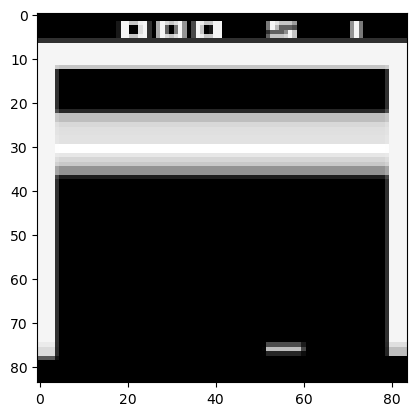

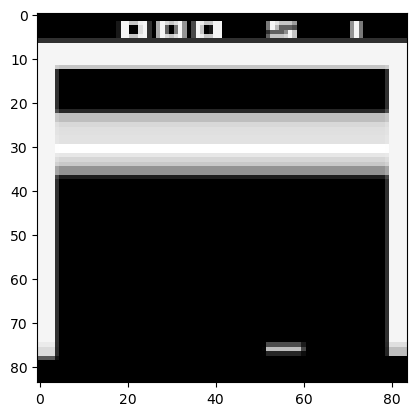

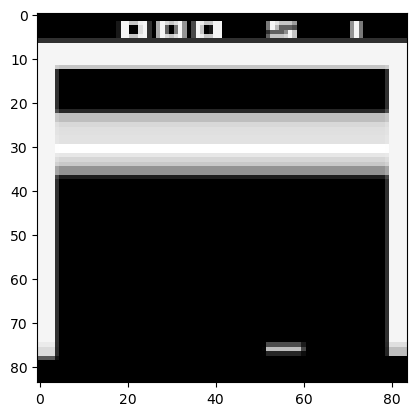

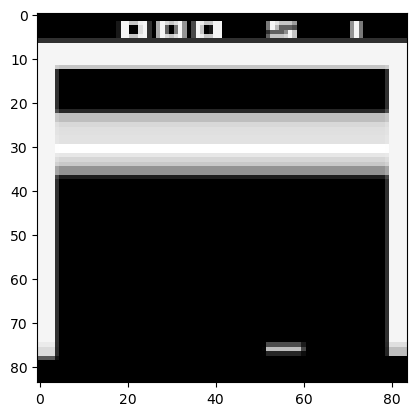

Episode 1 finished with total reward: 1


In [8]:
# https://ale.farama.org/environments/breakout/
ENV_NAME = "ALE/Breakout-v5" 

env = make_env(ENV_NAME,
                video_folder='./videos/random',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

for episode_num in range(1):
    obs, info = env.reset()
    show_observation_stack(obs)
    reward_total = 0
    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # seleccionamos una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(action)
        reward_total += reward
        episode_over = terminated or truncated
    print(f"Episode {episode_num + 1} finished with total reward: {reward_total}")

env.close()

Además, podemos mostrar los videos capturados por el entorno de Atari de la siguiente manera:

In [9]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/random/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

# Exploración del entorno

In [10]:
print("Actions shape:",env.action_space)
print("Observation shape:",env.observation_space.shape)
env.reset()
next_state, reward, terminated, truncated, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {terminated},\n {info}")

Actions shape: Discrete(4)
Observation shape: (4, 84, 84)
(4, 84, 84),
 0,
 False,
 {'lives': 5, 'episode_frame_number': 9, 'frame_number': 755}


### Acciones
...

### Observaciones
...

# Deep Q Learning

Deep Q Learning extiende el algoritmo clásico de Q-learning al emplear una **red neuronal profunda** como aproximador de la función de valor $Q(s,a)$. Inspirado en Mnih et al. (2013), este método utiliza una **red convolucional** para procesar directamente las imágenes del entorno Atari, un **replay buffer** para romper la correlación temporal de las muestras. La política sigue un esquema **ε-greedy**, balanceando exploración y explotación, y se entrena minimizando el error de la ecuación de Bellman sobre lotes de transiciones muestreadas de manera aleatoria.

<p align="center">
  <img src="https://www.researchgate.net/profile/Faris-Mismar/publication/327045314/figure/fig4/AS:819677282455553@1572437701142/Structure-of-the-neural-network-used-for-the-Deep-Q-learning-Network-implementation-with.png" alt="DQN"/>
</p>

Fuente: [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)

## Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.


> Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**

In [11]:
from replay_memory import ReplayMemory, Transition

# Creamos la memoria de repetición
replay_memory = ReplayMemory(3)

# Añadimos transiciones a la memoria (solo las 3 últimas se guardan)
replay_memory.add('state1', 'action1', 'reward1', 'done1', 'next_state1' )
replay_memory.add('state2', 'action2', 'reward2', 'done2', 'next_state2')
replay_memory.add('state3', 'action3', 'reward3', 'done3', 'next_state3')
replay_memory.add('state4', 'action4', 'reward4', 'done4', 'next_state4')

# Mostramos el tamaño de la memoria
print(f"Memory size: {len(replay_memory)}\n")

# Mostramos un sample de la memoria
sampled = replay_memory.sample(2)
print(f"Memory sample:")
for i, sample in enumerate(sampled):
    print(f"Sample {i}: {sample}")


Memory size: 3

Memory sample:
Sample 0: Transition(state='state2', action='action2', reward='reward2', done='done2', next_state='next_state2')
Sample 1: Transition(state='state4', action='action4', reward='reward4', done='done4', next_state='next_state4')


## Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

> Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**. Se recomienda empezar por una arquitectura simple como la que se muestra en el paper de Mnih et al. (2013) y luego experimentar con arquitecturas más complejas.

In [26]:
from dqn_cnn_model import DQN_CNN_Model

# salida 4 neuronas
# 4X84X84


env = make_env(ENV_NAME,
                record_every=None,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )
print("Actions shape:",env.action_space)
print("Observatiion shape:",env.observation_space.shape)

env.close()

cnn_model = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
summary(cnn_model, input_size=(32, SKIP_FRAMES, SCREEN_SIZE, SCREEN_SIZE), device=DEVICE) # 32 es el batch size

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -8046021


Actions shape: Discrete(4)
Observatiion shape: (4, 84, 84)
DQN_CNN_Model
tensor([[[[ 3.8298e-01,  2.6806e-01,  2.5141e-01,  ...,  4.2954e-01,
            4.4661e-01, -1.1810e-02],
          [ 2.0855e-01,  2.7313e-01,  3.0700e-01,  ...,  2.9180e-01,
            1.9062e-01,  1.0065e-01],
          [ 2.3984e-01,  8.8783e-02,  2.6453e-01,  ...,  4.4382e-01,
            4.3022e-01,  4.2069e-01],
          ...,
          [ 5.1036e-01,  2.4301e-01,  3.8012e-01,  ...,  6.7376e-02,
            2.9338e-01,  4.2508e-01],
          [ 5.0536e-01,  3.7598e-01,  4.3043e-01,  ..., -1.3721e-01,
            4.4727e-01,  4.6815e-01],
          [ 4.0023e-01,  2.6350e-01,  3.8204e-01,  ...,  3.4208e-01,
            2.1183e-01,  2.5340e-01]],

         [[ 3.1953e-01,  1.9179e-01, -1.2901e-01,  ...,  5.2836e-02,
           -7.4060e-03,  7.9924e-02],
          [ 3.5470e-01,  1.7115e-01,  6.8759e-01,  ...,  4.4874e-01,
           -5.7803e-02,  5.1668e-01],
          [ 2.1582e-01,  3.2955e-01,  7.7581e-02,  ...

Layer (type:depth-idx)                   Output Shape              Param #
DQN_CNN_Model                            [32, 4]                   --
├─Conv2d: 1-1                            [32, 16, 20, 20]          4,112
├─Conv2d: 1-2                            [32, 32, 9, 9]            8,224
├─Linear: 1-3                            [32, 256]                 663,808
├─Linear: 1-4                            [32, 4]                   1,028
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 95.22
Input size (MB): 3.61
Forward/backward pass size (MB): 2.37
Params size (MB): 2.71
Estimated Total Size (MB): 8.69

La red esta definida para que reciba un tensor de 4 dimensiones (batch_size, num_frames, height, width) y devuelve un tensor de 2 dimensiones (batch_size, num_actions). La función `forward` es la encargada de definir el flujo de datos a través de la red. En este caso, se utiliza una red convolucional seguida de capas totalmente conectadas

In [13]:
obs_tensor_batch = torch.rand((NUM_STACKED_FRAMES,SCREEN_SIZE,SCREEN_SIZE)).unsqueeze(0).to(DEVICE) # Añadimos una dimensión para el batch y lo pasamos al dispositivo
print(f"Q-values shape: {cnn_model(obs_tensor_batch).shape}") # shape: (1, num_actions) 

tensor([[[[ 0.1625,  0.1798,  0.5443,  ...,  0.0175,  0.4630,  0.1263],
          [ 0.2655,  0.1034,  0.6753,  ...,  0.4287,  0.4282,  0.3533],
          [ 0.3433,  0.1167,  0.3616,  ...,  0.8201,  0.3788,  0.3817],
          ...,
          [-0.1813,  0.1185,  0.2125,  ...,  0.3709,  0.2692,  0.1856],
          [ 0.2220,  0.3051,  0.2484,  ...,  0.5312,  0.3812,  0.0856],
          [ 0.1113,  0.1487,  0.4480,  ...,  0.2680,  0.2104,  0.1223]],

         [[-0.1758, -0.2628, -0.3234,  ..., -0.2383, -0.2934, -0.1778],
          [-0.3038, -0.2483, -0.4533,  ..., -0.1777, -0.2565,  0.0714],
          [-0.3583, -0.3465, -0.0811,  ..., -0.0145, -0.2446, -0.2315],
          ...,
          [ 0.0733, -0.1532, -0.0207,  ..., -0.2797, -0.1933, -0.1451],
          [ 0.0398, -0.2139, -0.0827,  ..., -0.2497, -0.1481,  0.0799],
          [-0.2397, -0.2998, -0.2447,  ...,  0.1765, -0.2922, -0.3653]],

         [[-0.0992, -0.3275,  0.0228,  ...,  0.1958,  0.1410, -0.0844],
          [ 0.0097,  0.1943, -

Los valores de Q se obtienen a partir de la salida de la red, cada columna representa el valor Q para cada acción posible en el estado actual. 

In [14]:
cnn_model(obs_tensor_batch) 

tensor([[[[ 0.1625,  0.1798,  0.5443,  ...,  0.0175,  0.4630,  0.1263],
          [ 0.2655,  0.1034,  0.6753,  ...,  0.4287,  0.4282,  0.3533],
          [ 0.3433,  0.1167,  0.3616,  ...,  0.8201,  0.3788,  0.3817],
          ...,
          [-0.1813,  0.1185,  0.2125,  ...,  0.3709,  0.2692,  0.1856],
          [ 0.2220,  0.3051,  0.2484,  ...,  0.5312,  0.3812,  0.0856],
          [ 0.1113,  0.1487,  0.4480,  ...,  0.2680,  0.2104,  0.1223]],

         [[-0.1758, -0.2628, -0.3234,  ..., -0.2383, -0.2934, -0.1778],
          [-0.3038, -0.2483, -0.4533,  ..., -0.1777, -0.2565,  0.0714],
          [-0.3583, -0.3465, -0.0811,  ..., -0.0145, -0.2446, -0.2315],
          ...,
          [ 0.0733, -0.1532, -0.0207,  ..., -0.2797, -0.1933, -0.1451],
          [ 0.0398, -0.2139, -0.0827,  ..., -0.2497, -0.1481,  0.0799],
          [-0.2397, -0.2998, -0.2447,  ...,  0.1765, -0.2922, -0.3653]],

         [[-0.0992, -0.3275,  0.0228,  ...,  0.1958,  0.1410, -0.0844],
          [ 0.0097,  0.1943, -

tensor([[-0.0188,  0.0008,  0.0328,  0.0380]], device='mps:0',
       grad_fn=<LinearBackward0>)

Podemos preguntar cuál es la acción con mayor valor Q en un estado.

In [15]:
cnn_model(obs_tensor_batch).max(1)

tensor([[[[ 0.1625,  0.1798,  0.5443,  ...,  0.0175,  0.4630,  0.1263],
          [ 0.2655,  0.1034,  0.6753,  ...,  0.4287,  0.4282,  0.3533],
          [ 0.3433,  0.1167,  0.3616,  ...,  0.8201,  0.3788,  0.3817],
          ...,
          [-0.1813,  0.1185,  0.2125,  ...,  0.3709,  0.2692,  0.1856],
          [ 0.2220,  0.3051,  0.2484,  ...,  0.5312,  0.3812,  0.0856],
          [ 0.1113,  0.1487,  0.4480,  ...,  0.2680,  0.2104,  0.1223]],

         [[-0.1758, -0.2628, -0.3234,  ..., -0.2383, -0.2934, -0.1778],
          [-0.3038, -0.2483, -0.4533,  ..., -0.1777, -0.2565,  0.0714],
          [-0.3583, -0.3465, -0.0811,  ..., -0.0145, -0.2446, -0.2315],
          ...,
          [ 0.0733, -0.1532, -0.0207,  ..., -0.2797, -0.1933, -0.1451],
          [ 0.0398, -0.2139, -0.0827,  ..., -0.2497, -0.1481,  0.0799],
          [-0.2397, -0.2998, -0.2447,  ...,  0.1765, -0.2922, -0.3653]],

         [[-0.0992, -0.3275,  0.0228,  ...,  0.1958,  0.1410, -0.0844],
          [ 0.0097,  0.1943, -

torch.return_types.max(
values=tensor([0.0380], device='mps:0', grad_fn=<MaxBackward0>),
indices=tensor([3], device='mps:0'))

En el siguiente ejemplo vamos a ver cómo tomar los valores de acciones deseables para un conjunto de estados. 

In [16]:
# Creamos 3 observaciones aleatorias para probar el modelo
obs_ran1 = torch.rand(4, 84, 84)
obs_ran2 = torch.rand(4, 84, 84)
obs_ran3 = torch.rand(4, 84, 84)

batch = torch.stack([obs_ran1, obs_ran2, obs_ran3], dim=0).to(DEVICE) # shape: (3, 4, 84, 84)
print(f"Batch shape: {batch.shape}")

actions =  torch.tensor([1, 2, 3], device=DEVICE).unsqueeze(1) # queremos la acción 1 para la primera observación, la acción 2 para la segunda y la acción 3 para la tercera

Q_test = cnn_model(batch)
print(f"Q-values: {Q_test}")
print(f"Q-values: {Q_test.gather(1, actions)}") # https://pytorch.org/docs/main/generated/torch.gather.html

Batch shape: torch.Size([3, 4, 84, 84])
tensor([[[[ 2.5055e-01,  1.4621e-01,  3.4483e-01,  ...,  7.2907e-02,
            1.6594e-01,  2.5123e-01],
          [ 3.2560e-01,  2.4170e-01,  2.1694e-01,  ..., -8.1574e-02,
            3.2264e-01,  4.5829e-01],
          [ 1.0169e-01,  3.9154e-01,  7.6013e-02,  ...,  3.2928e-01,
            5.9308e-01,  3.3485e-01],
          ...,
          [ 4.1943e-01,  1.6128e-01,  3.7530e-01,  ...,  8.2447e-02,
            4.2359e-02,  5.8907e-01],
          [ 2.5792e-01,  2.9037e-01,  2.5821e-01,  ...,  4.1490e-01,
            1.0749e-01,  3.2689e-01],
          [ 1.8673e-01,  4.1468e-01,  3.2184e-01,  ...,  2.4025e-01,
            5.6752e-01,  6.4912e-01]],

         [[-1.7987e-01, -2.8921e-01,  5.3042e-02,  ..., -2.3973e-01,
           -1.6701e-01, -1.9644e-01],
          [-1.0478e-01, -3.6281e-01, -6.9505e-01,  ..., -2.8838e-01,
           -2.9679e-01, -7.1677e-03],
          [-2.2268e-01, -5.5801e-02, -9.7683e-02,  ..., -1.4448e-01,
            1.3591

## Phi 

La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym. Esta función pasa una observación de gym a un tensor de Pytorch y la normaliza.

> Técnicamente la función phi tiene más responsabilidades, como la de apilar los frames y el downsampling. En nuestro caso se lo delegamos a los wrappers de gymnasium.

In [17]:
def process_state(obs):
    """
    Preprocess the state to be used as input for the model (transform to tensor).
    """
    return torch.tensor(obs, dtype=torch.float32, device=DEVICE) / 255.0

obs, _ = env.reset()
obs_tensor = process_state(obs)
print(f"Observation shape: {obs_tensor.shape}")

Observation shape: torch.Size([4, 84, 84])


## Agente

Vamos a definir una clase agente (abstracto), encargado de interactuar con el ambiente y entrenar los modelos. Los métdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

> Para implementar esta funcionalidad se debe modificar los archivos **abstract_agent.py** y **dqn_agent.py**.

Funciones a completar:


1. **init**: que inicializa los parametros del agente.

2. **compute_epsilon**: que computa el valor actual de epsilon en base al número de pasos actuales y si esta entrenando o no.

3. **select_action**: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. **train**: que entrena el agente por un número dado de episodios de largo determinado.

5. **record_test_episode**: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida.

## Entrenamiento

In [64]:
#Hiperparámetros de entrenamiento del agente DQN
# TOTAL_STEPS = 10_000_000
TOTAL_STEPS = 10_000
EPISODES = 10_000
STEPS_PER_EPISODE = 20_000

EPSILON_INI = 1
EPSILON_MIN = 0.05
# EPSILON_ANNEAL_STEPS = 1_000_000
EPSILON_ANNEAL_STEPS = 10_000

EPISODE_BLOCK = 100

BATCH_SIZE = 32
BUFFER_SIZE = 50_000

GAMMA = 0.995
LEARNING_RATE = 1e-5

In [65]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_training',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -69557341


empty cache


In [83]:
import importlib
import replay_memory  # or whatever module you changed
import dqn_cnn_model
import dqn_agent
import abstract_agent
importlib.reload(replay_memory)
importlib.reload(dqn_cnn_model)
importlib.reload(dqn_agent)
importlib.reload(abstract_agent)
from dqn_cnn_model import DQN_CNN_Model
from dqn_agent import DQNAgent

from abstract_agent import Agent

In [84]:
net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

In [85]:
dqn_agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, device=DEVICE)

In [86]:
dqn_rewards = dqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

env.close()

Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3


Entrenando:   0%|          | 1/10000 [00:30<85:37:58, 30.83s/episode, reward=4, epsilon=0.973, steps=286]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1


Entrenando:   0%|          | 2/10000 [00:57<79:03:31, 28.47s/episode, reward=3.5, epsilon=0.948, steps=547]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 3/10000 [01:25<77:58:48, 28.08s/episode, reward=3.33, epsilon=0.923, steps=807]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 4/10000 [01:42<65:51:37, 23.72s/episode, reward=2.75, epsilon=0.907, steps=983]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 5/10000 [01:59<59:23:31, 21.39s/episode, reward=2.4, epsilon=0.89, steps=1162] 

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 6/10000 [02:15<53:55:00, 19.42s/episode, reward=2.17, epsilon=0.875, steps=1319]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 7/10000 [02:30<50:17:51, 18.12s/episode, reward=2, epsilon=0.86, steps=1473]    

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.floa

Entrenando:   0%|          | 8/10000 [02:49<51:17:54, 18.48s/episode, reward=1.88, epsilon=0.841, steps=1671]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 9/10000 [03:04<47:56:23, 17.27s/episode, reward=1.78, epsilon=0.827, steps=1824]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 10/10000 [03:17<44:37:51, 16.08s/episode, reward=1.6, epsilon=0.815, steps=1950]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.floa

Entrenando:   0%|          | 11/10000 [03:32<43:14:43, 15.59s/episode, reward=1.45, epsilon=0.802, steps=2087]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 12/10000 [03:50<45:11:47, 16.29s/episode, reward=1.42, epsilon=0.785, steps=2265]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 13/10000 [04:12<49:47:25, 17.95s/episode, reward=1.46, epsilon=0.764, steps=2489]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.floa

Entrenando:   0%|          | 14/10000 [04:30<50:26:48, 18.19s/episode, reward=1.43, epsilon=0.745, steps=2680]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 15/10000 [04:48<50:23:05, 18.17s/episode, reward=1.4, epsilon=0.728, steps=2861] 

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.floa

Entrenando:   0%|          | 16/10000 [05:06<50:08:50, 18.08s/episode, reward=1.38, epsilon=0.711, steps=3042]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 17/10000 [05:24<49:29:49, 17.85s/episode, reward=1.35, epsilon=0.696, steps=3205]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 18/10000 [05:42<50:11:44, 18.10s/episode, reward=1.33, epsilon=0.678, steps=3393]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 19/10000 [05:58<48:20:05, 17.43s/episode, reward=1.32, epsilon=0.663, steps=3550]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.floa

Entrenando:   0%|          | 20/10000 [06:15<48:00:03, 17.31s/episode, reward=1.3, epsilon=0.646, steps=3722] 

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.floa

Entrenando:   0%|          | 21/10000 [06:40<54:05:54, 19.52s/episode, reward=1.38, epsilon=0.623, steps=3969]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 22/10000 [07:15<67:12:50, 24.25s/episode, reward=1.55, epsilon=0.59, steps=4319] 

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 23/10000 [07:34<62:41:25, 22.62s/episode, reward=1.52, epsilon=0.572, steps=4504]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 24/10000 [08:01<66:25:50, 23.97s/episode, reward=1.58, epsilon=0.548, steps=4763]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.floa

Entrenando:   0%|          | 25/10000 [08:29<69:21:11, 25.03s/episode, reward=1.6, epsilon=0.523, steps=5018] 

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 26/10000 [09:13<85:18:37, 30.79s/episode, reward=1.77, epsilon=0.483, steps=5437]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.floa

Entrenando:   0%|          | 27/10000 [09:44<85:52:00, 31.00s/episode, reward=1.85, epsilon=0.456, steps=5723]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 28/10000 [09:59<72:04:41, 26.02s/episode, reward=1.79, epsilon=0.444, steps=5854]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 29/10000 [10:17<66:04:25, 23.86s/episode, reward=1.76, epsilon=0.427, steps=6028]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 30/10000 [10:36<61:23:32, 22.17s/episode, reward=1.7, epsilon=0.411, steps=6198] 

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.floa

Entrenando:   0%|          | 31/10000 [11:04<66:20:47, 23.96s/episode, reward=1.74, epsilon=0.387, steps=6449]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.floa

Entrenando:   0%|          | 32/10000 [11:32<70:14:23, 25.37s/episode, reward=1.78, epsilon=0.363, steps=6708]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 33/10000 [11:59<71:01:45, 25.66s/episode, reward=1.76, epsilon=0.341, steps=6940]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 34/10000 [12:17<65:07:14, 23.52s/episode, reward=1.74, epsilon=0.325, steps=7103]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.floa

Entrenando:   0%|          | 35/10000 [12:38<62:58:55, 22.75s/episode, reward=1.71, epsilon=0.308, steps=7288]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 36/10000 [13:05<66:20:02, 23.97s/episode, reward=1.75, epsilon=0.286, steps=7518]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 37/10000 [13:27<64:40:37, 23.37s/episode, reward=1.73, epsilon=0.268, steps=7709]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 38/10000 [13:51<64:54:59, 23.46s/episode, reward=1.71, epsilon=0.249, steps=7908]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.floa

Entrenando:   0%|          | 39/10000 [14:09<60:50:03, 21.99s/episode, reward=1.69, epsilon=0.234, steps=8068]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 40/10000 [14:30<59:26:17, 21.48s/episode, reward=1.68, epsilon=0.217, steps=8239]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 41/10000 [15:06<71:36:29, 25.89s/episode, reward=1.68, epsilon=0.19, steps=8530] 

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 42/10000 [15:28<68:42:47, 24.84s/episode, reward=1.64, epsilon=0.172, steps=8712]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 43/10000 [15:58<72:26:49, 26.19s/episode, reward=1.63, epsilon=0.151, steps=8936]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.floa

Entrenando:   0%|          | 44/10000 [16:24<72:58:42, 26.39s/episode, reward=1.61, epsilon=0.131, steps=9152]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.floa

Entrenando:   0%|          | 45/10000 [16:56<76:54:43, 27.81s/episode, reward=1.62, epsilon=0.107, steps=9401]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 2
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0
 state.dtype = torch.floa

Entrenando:   0%|          | 46/10000 [17:44<94:21:22, 34.13s/episode, reward=1.65, epsilon=0.0745, steps=9742]

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 1
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 3
 state.dtype = torch.floa

Entrenando:   0%|          | 47/10000 [18:35<65:36:02, 23.73s/episode, reward=1.66, epsilon=0.05, steps=1e+4]  

 state.dtype = torch.float32
 state.dtype = torch.float32
 best_Action = 0


In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

dqn_agent.play(env, episodes=3)

env.close()

In [ ]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/dqn_validation/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

#### Graficas 
...

# Double Deep Q Learning

Double DQN mejora la versión clásica de DQN corrigiendo el sesgo de sobreestimación de los valores 
𝑄
Q. Para ello, desacopla la selección de la acción de su evaluación: en cada paso, la red online elige la acción que maximiza 
𝑄
Q, pero la red objetivo distinta estima el valor de esa acción. Esta separación reduce el sesgo hacia valores demasiado optimistas y aporta mayor estabilidad al entrenamiento. El resto de la estructura —replay buffer, política ε-greedy, etc— se mantiene igual que en DQN, aprovechando así un diseño casi idéntico al original pero con resultados más fiables .

Fuente: [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)

> Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

In [ ]:
from double_dqn_agent import DoubleDQNAgent

env = make_env(ENV_NAME,
                video_folder='./videos/ddqn_training',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )


modelo_a = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
modelo_b = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

ddqn_agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block = EPISODE_BLOCK, device=DEVICE)

ddqn_rewards = ddqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/ddqn_validation',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

ddqn_agent.play(env, episodes=3)

env.close()

In [ ]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/ddqn_validation/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

#### Graficas 
...

# Experimentación
Aquí con libertad total, pueden probar diferentes arquitecturas de red, diferentes hiperparámetros, diferentes técnicas de exploración, etc.
...

# Comparaciones, Resultados, Comentarios...
De aquí en adelante son libres de presentar como gusten los resultados comparativos de las técnicas.
...